# 03 - Feature Selection
This notebook applies various feature selection techniques (Random Forest, XGBoost, Chi-Square, RFE) 
to identify the most important predictors for heart disease and combines them into a final score.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.preprocessing import StandardScaler

## 1. Load and Prepare Data

In [3]:
# Load cleaned data
DATA_PATH = '../data/heart_disease.csv'
df = pd.read_csv(DATA_PATH)
print('Dataset shape:', df.shape)

# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Standardize features for model-based methods
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print('Features shape:', X.shape)
print('Target shape:', y.shape)

SELECT_K = 10
# For plots and titles
TOP_K = SELECT_K
TOTAL_FEATURES = X.shape[1]

Dataset shape: (303, 26)
Features shape: (303, 25)
Target shape: (303,)


## 2. Feature Selection Techniques

### 2.1. Feature Importance

#### Random Forest Feature Importance

Random Forest Feature Importance:
     feature  importance
3    thalach    0.108050
4    oldpeak    0.094148
11    cp_4.0    0.092467
18    ca_0.0    0.090486
24  thal_7.0    0.077979


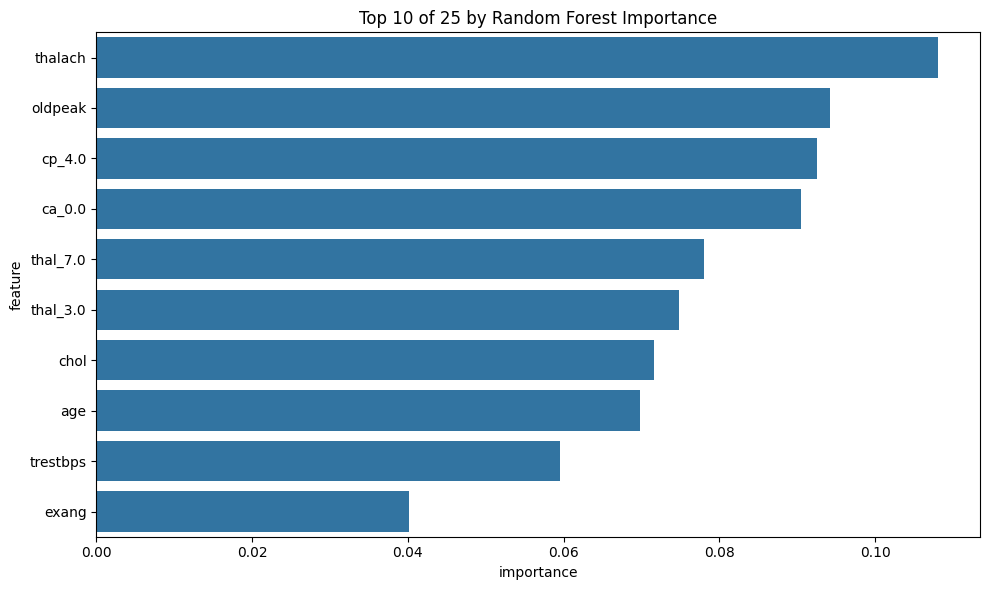

In [4]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

rf_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print('Random Forest Feature Importance:')
print(rf_importances.head())

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=rf_importances.head(TOP_K))
plt.title(f'Top {SELECT_K} of {TOTAL_FEATURES} by Random Forest Importance')
plt.tight_layout()
plt.show()

#### XGBoost Feature Importance

c:\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:50:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Feature Importance:
     feature  importance
22  thal_3.0    0.312917
11    cp_4.0    0.213483
18    ca_0.0    0.078517
24  thal_7.0    0.052628
7      exang    0.043381


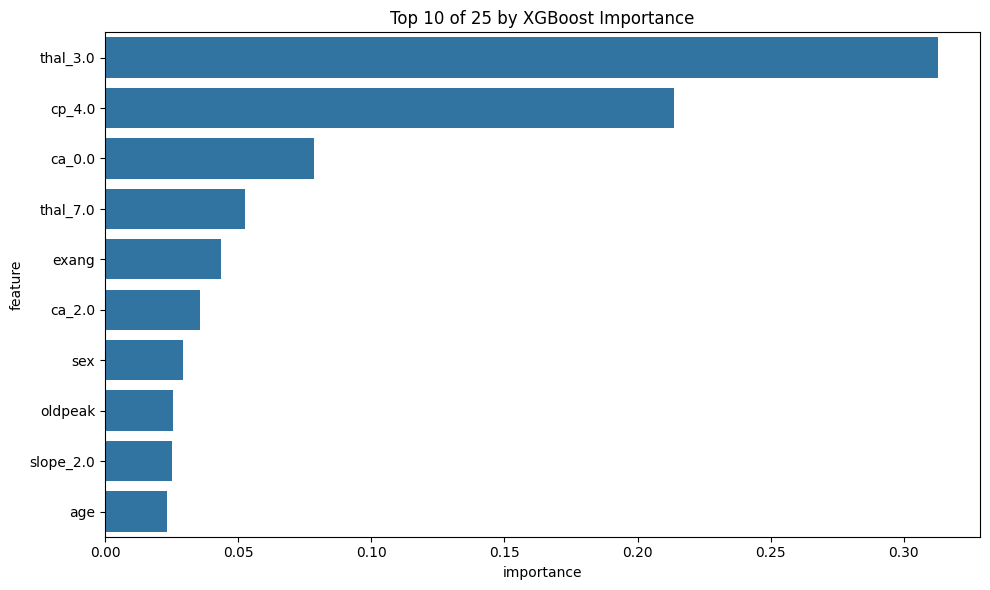

In [5]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_scaled, y)

xgb_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False)

print('XGBoost Feature Importance:')
print(xgb_importances.head())

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=xgb_importances.head(TOP_K))
plt.title(f'Top {SELECT_K} of {TOTAL_FEATURES} by XGBoost Importance')
plt.tight_layout()
plt.show()

### 2.2. Recursive Feature Elimination (RFE)

In [6]:
rfe = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=SELECT_K)
rfe.fit(X_scaled, y)

rfe_results = pd.DataFrame({
    'feature': X.columns,
    'selected': rfe.support_,
    'ranking': rfe.ranking_
}).sort_values('ranking')

print('RFE Results:')
print(rfe_results.head())

RFE Results:
     feature  selected  ranking
0        age      True        1
22  thal_3.0      True        1
18    ca_0.0      True        1
11    cp_4.0      True        1
7      exang      True        1


### 2.3. Chi-Square Test

Chi-Square Test Results:
     feature  chi2_score   p_value
22  thal_3.0   23.860423  0.000001
11    cp_4.0   23.479849  0.000001
24  thal_7.0   20.330961  0.000007
18    ca_0.0   20.264871  0.000007
7      exang   16.420164  0.000051


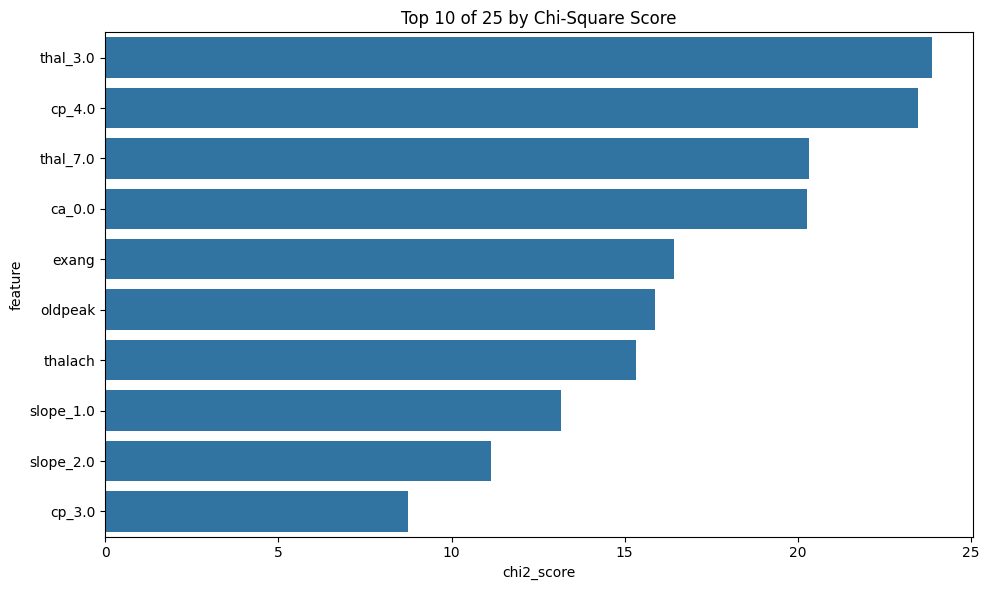

In [7]:
# Ensure non-negative values for chi2
X_scaled_positive = X_scaled - X_scaled.min() + 1e-6

selector = SelectKBest(score_func=chi2, k='all')
selector.fit(X_scaled_positive, y)

chi2_scores = pd.DataFrame({
    'feature': X.columns,
    'chi2_score': selector.scores_,
    'p_value': selector.pvalues_
}).sort_values('chi2_score', ascending=False)

print('Chi-Square Test Results:')
print(chi2_scores.head())

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='chi2_score', y='feature', data=chi2_scores.head(TOP_K))
plt.title(f'Top {SELECT_K} of {TOTAL_FEATURES} by Chi-Square Score')
plt.tight_layout()
plt.show()

## 3. Combine and Rank Features

In [8]:
# Combine results from all methods
combined_results = pd.DataFrame({
    'feature': X.columns,
    'rf_importance': rf_importances.set_index('feature').loc[X.columns]['importance'],
    'xgb_importance': xgb_importances.set_index('feature').loc[X.columns]['importance'],
    'chi2_score': chi2_scores.set_index('feature').loc[X.columns]['chi2_score'],
    'rfe_ranking': rfe_results.set_index('feature').loc[X.columns]['ranking']
})

# Normalize scores to be on the same scale (0-1)
combined_results['rf_norm'] = combined_results['rf_importance'] / combined_results['rf_importance'].max()
combined_results['xgb_norm'] = combined_results['xgb_importance'] / combined_results['xgb_importance'].max()
combined_results['chi2_norm'] = combined_results['chi2_score'] / combined_results['chi2_score'].max()
combined_results['rfe_norm'] = 1 - (combined_results['rfe_ranking'] - 1) / (combined_results['rfe_ranking'].max() - 1)

# Calculate final score (average of normalized scores)
combined_results['final_score'] = combined_results[['rf_norm', 'xgb_norm', 'chi2_norm', 'rfe_norm']].mean(axis=1)
combined_results = combined_results.sort_values('final_score', ascending=False)

print('Combined Feature Importance:')
print(combined_results.head(SELECT_K))

Combined Feature Importance:
             feature  rf_importance  xgb_importance  chi2_score  rfe_ranking  \
thal_3.0    thal_3.0       0.074746        0.312917   23.860423            1   
cp_4.0        cp_4.0       0.092467        0.213483   23.479849            1   
ca_0.0        ca_0.0       0.090486        0.078517   20.264871            1   
thal_7.0    thal_7.0       0.077979        0.052628   20.330961            1   
thalach      thalach       0.108050        0.014410   15.319437            1   
oldpeak      oldpeak       0.094148        0.025340   15.863514            1   
exang          exang       0.040142        0.043381   16.420164            1   
age              age       0.069767        0.023130    4.382292            1   
slope_1.0  slope_1.0       0.033787        0.021848   13.169573            2   
chol            chol       0.071585        0.017114    0.638456            1   

            rf_norm  xgb_norm  chi2_norm  rfe_norm  final_score  
thal_3.0   0.691773  1.0

## 4. Visualize and Save Top Features

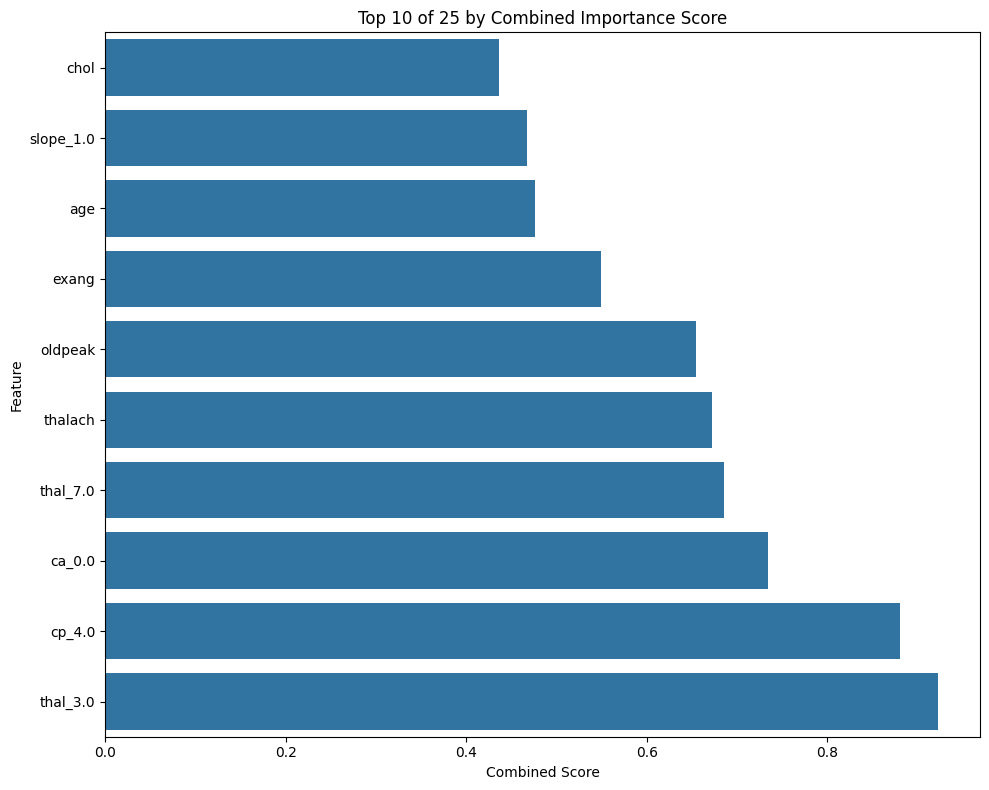

Top 10 features written to ../results/evaluation_metrics.txt


In [9]:
# Visualize combined feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='final_score', y='feature', data=combined_results.head(TOP_K).sort_values('final_score', ascending=True))
plt.title(f'Top {SELECT_K} of {TOTAL_FEATURES} by Combined Importance Score')
plt.xlabel('Combined Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Save top-k features summary
top_features = combined_results.head(SELECT_K)
metrics_path = '../results/evaluation_metrics.txt'
os.makedirs(os.path.dirname(metrics_path), exist_ok=True)
with open(metrics_path, 'a', encoding='utf-8') as f:
    f.write(f'=== Feature Selection: Top {SELECT_K} Features (Combined Score) ===\n')
    f.write(top_features[['feature', 'final_score']].to_string(index=False))
    f.write('\n\n')
print(f'Top {SELECT_K} features written to {metrics_path}')